## ❤️‍🩹 HEART DISEASE DETECTOR


This database shows a set of information related to cardiac diseases, and a class representing if the subjects have or no any cardiac disease. 

Its importante to note that the database doesnt specify the disease, only if the subject haves it or not.


We consider this databse inespecific for diagnosis, but importance to determine WHAT coontributes most to any cardiac disease (Feature Importance) 😷

ref: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool, cv, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, RocCurveDisplay, confusion_matrix
from scipy.stats import chi2_contingency
import scipy.stats as stats
import shap
import seaborn as sns
import plotly.express as px

from utils import *

In [22]:
# Reading the heart disease database

df = pd.read_csv('dataset/archive.zip')

Ok, what we have here? 🔎

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


We have features with "object" Dtype. We'll change this later to string to make possible to catboost use it.

How the data looks like? 🔎

In [24]:
# How the data looks like?
df.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0



Let's see if there's anything missing 🗃️

In [25]:
# Lets see if there is missing data..

missing_values_per_row = df.isnull().sum(axis=1)
num_rows_with_missing_data = (missing_values_per_row > 0).sum()
print(f'Rows with missing data (qty): {num_rows_with_missing_data}')


Rows with missing data (qty): 0


In [26]:
# Change the data type 'object' to 'string' in order to process the data.

for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].astype("string")

Analyzing numeric features with boxplot 🔢

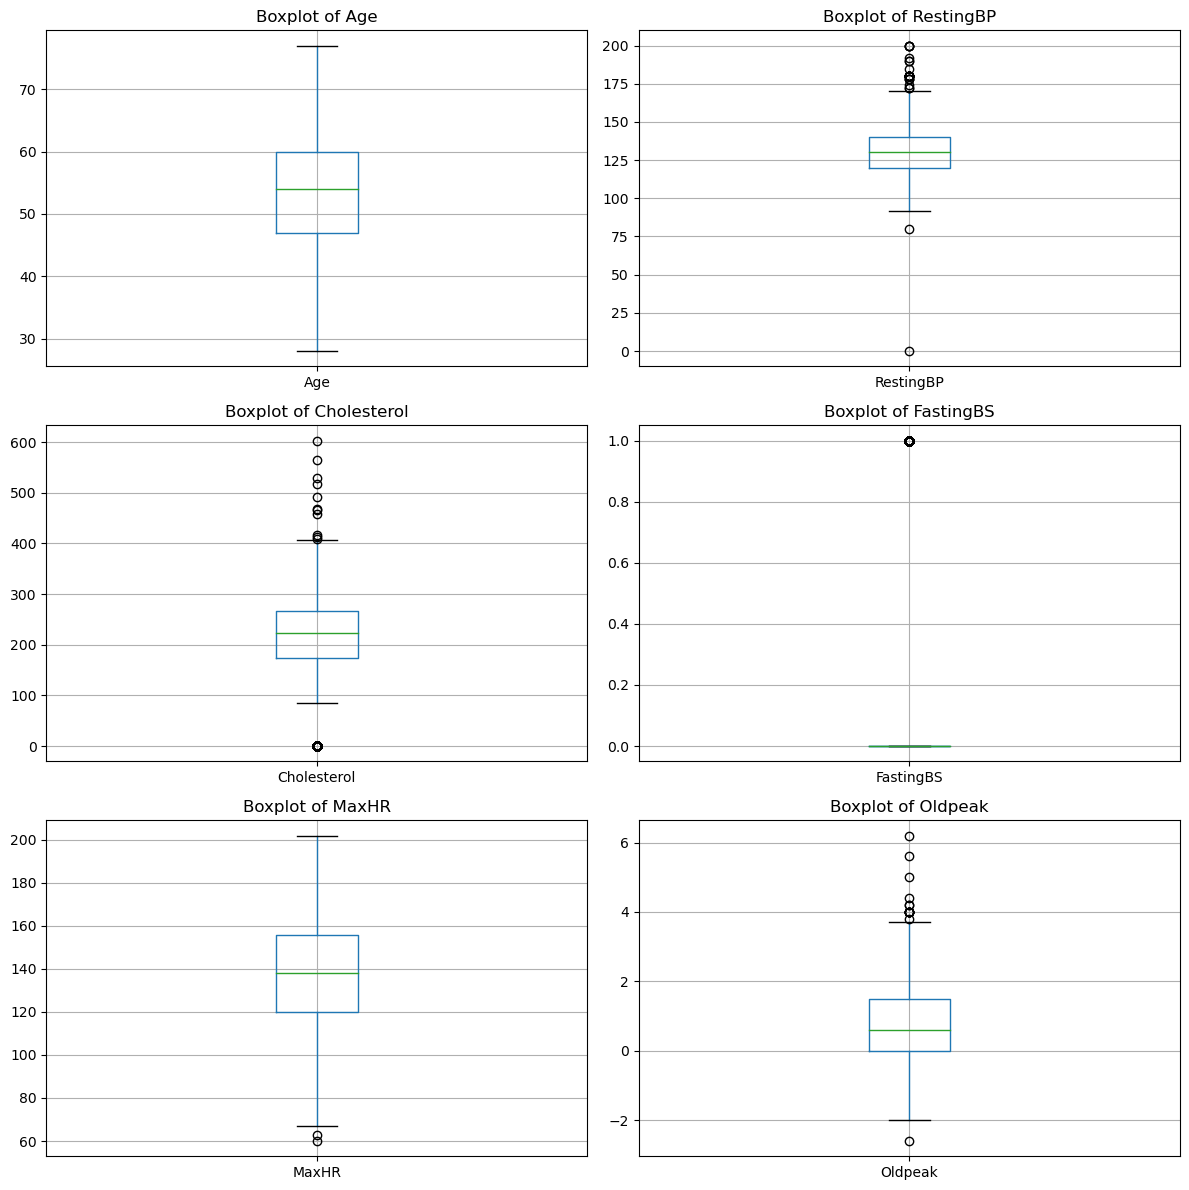

In [27]:
columns_to_plot = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

num_columns = len(columns_to_plot)
num_rows = (num_columns + 1) // 2  

fig, axes = plt.subplots(num_rows, 2, figsize=(12, 12))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    df.boxplot(column=column, ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')

plt.tight_layout()

plt.show()



Except for FastingBS, all features have relatively equal distributions across quartiles. In FastingBS, the data is distributed closer to the median, wich is 0.

In [28]:
# Peaking FastingBS to confirm:

df.FastingBS.describe()

count    918.000000
mean       0.233115
std        0.423046
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: FastingBS, dtype: float64

Analyzing categorical (string) features with bars 🔤

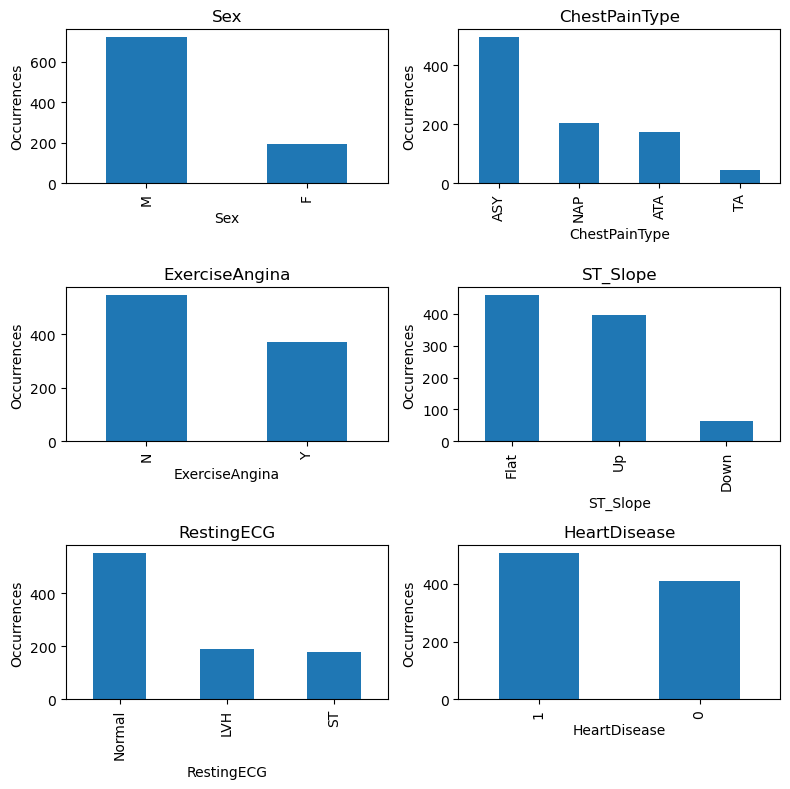

In [29]:
columns_to_plot = ['Sex', 'ChestPainType', 'ExerciseAngina', 'ST_Slope', 'RestingECG','HeartDisease']

num_columns = len(columns_to_plot)
num_rows = (num_columns + 1) // 2  

fig, axes = plt.subplots(num_rows, 2, figsize=(8, 8))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    counts = df[column].value_counts()
    counts.plot(kind='bar', ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Occurrences')

plt.tight_layout()

plt.show()

Notes:
 - Most of subjects base are cisgender man. 🤷🏻‍♂️
 - Classes (Heat Disease) are not unbalanced.

Checking if any of the numeric data are normally-distributed, in order to allow further analysis

In [30]:
normality_test(df, ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'])

,Coluna,p_valor,Normal?
0,Age,2.170367e-05,False
1,RestingBP,1.494997e-15,False
2,Cholesterol,6.972956e-27,False
3,FastingBS,3.783506e-44,False
4,MaxHR,1.683220e-04,False
5,Oldpeak,8.269499e-28,False


Not normally-distributed data here.

Now we'll see if there is significant differences between the data of the classes.

In [31]:
df_class_0 = df[df['HeartDisease'] == 0]
df_class_1 = df[df['HeartDisease'] == 1]

differences_test(df_class_0, df_class_1, ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'])

,Coluna,p_valor,Different?
0,Age,3.007953e-18,False
1,RestingBP,1.095315e-03,False
2,Cholesterol,9.308309e-13,False
3,FastingBS,1.753598e-16,False
4,MaxHR,1.137786e-36,False
5,Oldpeak,2.390772e-37,False


The numeric data are not statistically different between classes. Here is a attention point to the modelling quality.

Searching for similarities between categorical features

In [32]:
contingency_table = pd.DataFrame()

for column in df.columns:
    if df[column].dtype == 'string':
        contingency_table = pd.crosstab(df[column], df.index, rownames=[column])

chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Square Statistics: {chi2}")
print(f"p_value: {p}")

alpha = 0.05  
if p < alpha:
    print("There is a statistically significant association between the variables.")
else:
    print("There is NO statistically significant association between the variables.")

Chi-Square Statistics: 1836.0000000000002
p_value: 0.4824450923275001
There is NO statistically significant association between the variables.


The categorical data being not associated it's a good signal for the modelling!

Finally, lets see if the numerica data are correlated.

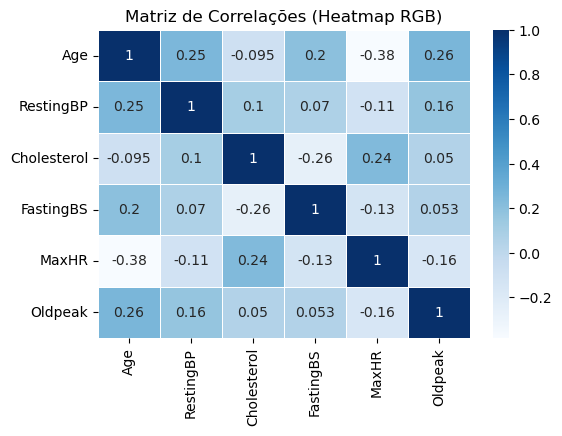

In [33]:
df[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(df[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']].corr()
, cmap='Blues', annot=True, linewidths=0.5)

plt.title('Matriz de Correlações (Heatmap RGB)')

plt.show()

No important correlation here! 

Starting the modelling process using CatBoost 😸

In [34]:
X = df[['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']]
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']

model = CatBoostClassifier(iterations=200, 
                           depth=3, 
                           learning_rate=0.01, 
                           cat_features=categorical_features, 
                           early_stopping_rounds=10,
                           random_seed=42,
                           custom_loss=['AUC', 'Accuracy']
                           )

model.fit(
    X_train, 
    y_train,
    eval_set=(X_test, y_test),
    verbose=True,
    plot=True
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6867164	test: 0.6875068	best: 0.6875068 (0)	total: 9.79ms	remaining: 1.95s
1:	learn: 0.6822097	test: 0.6834818	best: 0.6834818 (1)	total: 25.8ms	remaining: 2.56s
2:	learn: 0.6760865	test: 0.6783149	best: 0.6783149 (2)	total: 41.4ms	remaining: 2.72s
3:	learn: 0.6704484	test: 0.6734222	best: 0.6734222 (3)	total: 54.7ms	remaining: 2.68s
4:	learn: 0.6631072	test: 0.6669262	best: 0.6669262 (4)	total: 67.4ms	remaining: 2.63s
5:	learn: 0.6568614	test: 0.6607789	best: 0.6607789 (5)	total: 79.9ms	remaining: 2.58s
6:	learn: 0.6504723	test: 0.6551594	best: 0.6551594 (6)	total: 93.2ms	remaining: 2.57s
7:	learn: 0.6453489	test: 0.6505583	best: 0.6505583 (7)	total: 104ms	remaining: 2.5s
8:	learn: 0.6396695	test: 0.6449658	best: 0.6449658 (8)	total: 115ms	remaining: 2.44s
9:	learn: 0.6336749	test: 0.6400305	best: 0.6400305 (9)	total: 127ms	remaining: 2.42s
10:	learn: 0.6284798	test: 0.6352218	best: 0.6352218 (10)	total: 139ms	remaining: 2.39s
11:	learn: 0.6233514	test: 0.6308515	best: 0.6

Make predictions over test data 🔮

In [35]:
y_pred = model.predict(X_test)

Fingers-crossed: How the model performed?

In [36]:
metrics_df = pd.DataFrame(columns=['Accuracy', 'F1-Score', 'Recall', 'Precision', 'AUC-ROC'])

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] 
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_prob)
metrics_df = metrics_df.append({
    'Accuracy': accuracy,
    'F1-Score': f1,
    'Recall': recall,
    'Precision': precision,
    'AUC-ROC': auc_roc}, ignore_index=True)

metrics_df

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Accuracy,F1-Score,Recall,Precision,AUC-ROC
0,0.86413,0.881517,0.869159,0.894231,0.92754


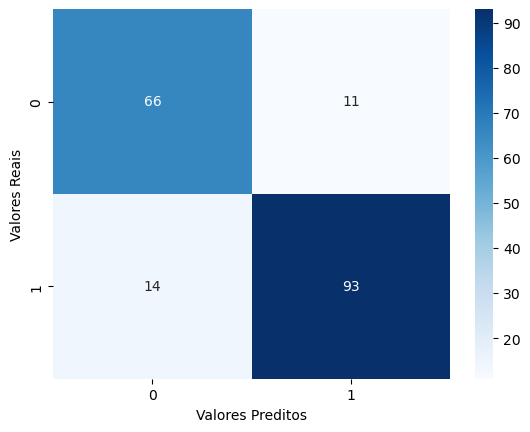

In [37]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

🎉 The CatBoost model trained for heart disease classification demonstrated <b>solid performance</b> on both training and validation sets. 
With an accuracy of approximately 86.41%, the model correctly classified the majority of samples in the validation set. 

⭐ Furthermore, the model achieved an F1-Score of around 0.8815, highlighting its ability to balance precision and recall. The recall of approximately 86.92% indicates the model's ability to identify cases of heart disease, while the accuracy of approximately 89.42% demonstrates that the positive predictions are reliable.

🤩 The AUC-ROC metric, with a value of around 0.92754, reflects the high discriminatory capacity of the model. In summary, the CatBoost model is effective in classifying heart diseases, with high performance in identifying positive cases and a solid ability to discriminate between classes.

Determining what's the importance (weight) of each feature in detecting heart disease. 

In [38]:
feature_importances = model.get_feature_importance(prettified=True)
feature_importances

,Feature Id,Importances
0,ST_Slope,41.714824
1,ChestPainType,16.771889
2,ExerciseAngina,9.779473
3,Cholesterol,8.512968
4,Oldpeak,8.311980
5,Sex,6.695697
6,Age,3.776867
7,FastingBS,2.300005
8,MaxHR,1.646951
9,RestingBP,0.342215


<AxesSubplot:ylabel='Feature Id'>

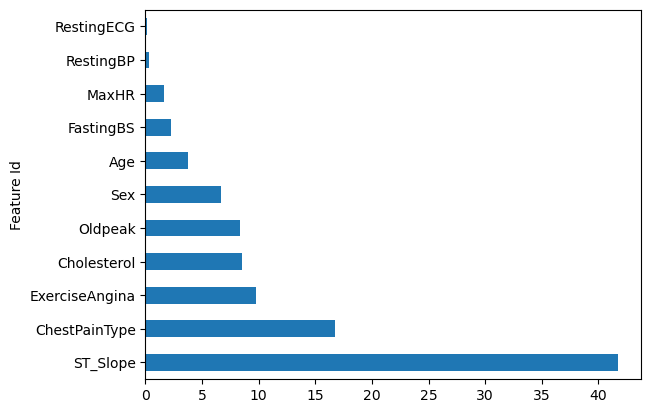

In [39]:
feature_importances.plot(kind='barh', x='Feature Id', y='Importances', legend=False)

We can see that, and attention to: 
 - ST_Slope: Can be checked with ECG exam: ref: https://pubmed.ncbi.nlm.nih.gov/3739881/
 - ChestPainType: Always keep in mind and tell your doctor the type of chest pain you're feeling.
 - ExerciseAngina: Chest pain during exercises is a good teller of heart disease.
 - Cholesterol: Keep your blood exams updated and consult your doctor on how to improve your feeding habits.


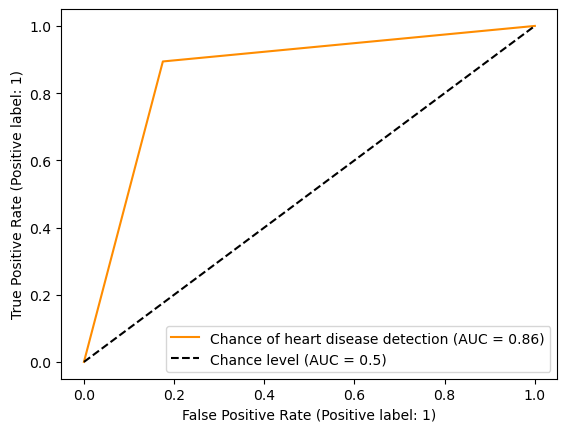

In [40]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_pred,
    y_test,
    name=f"Chance of heart disease detection",
    color="darkorange",
    plot_chance_level=True)
   

In [41]:
print(model.get_best_score())

{'learn': {'Accuracy': 0.8787465940054496, 'Logloss': 0.3368250697477927}, 'validation': {'Accuracy': 0.8641304347826086, 'Logloss': 0.3632791385863822, 'AUC': 0.9275397499696565}}


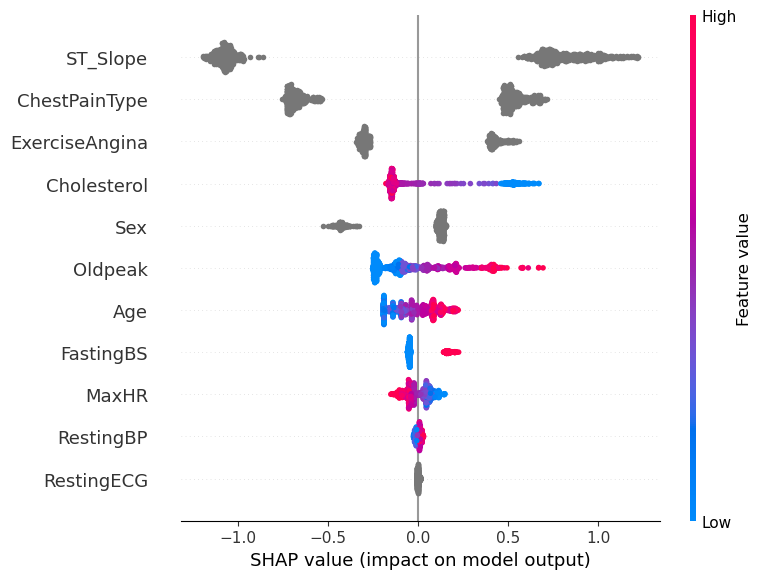

In [42]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

Notes over SHAP:
 - ST_Slope, ChestPainType and ExerciseAngina can produce equally positive and negative impacts in the model results.
 - Cholesterol impacts more positivelly in the model, meaning that when the cholesterol it's high, it impacts, but when its low, compared to the others, its a lesser impact.


<b>Conclusion:</b>

The heart disease classification project using CatBoost revealed promising results. Feature importance analysis highlighted the importance of features such as ST_Slope, ChestPainType, ExerciseAngina and Cholesterol in predicting heart disease. These findings provide valuable insights to guide clinical assessment and patient awareness. With an accuracy of approximately 86.41% and an AUC-ROC of approximately 0.92754, the model demonstrates high performance in identifying cardiac cases. These metrics, along with feature interpretation, highlight the model's potential as a valuable tool to assist healthcare professionals in the early detection and treatment of heart disease.